# Data and Setup
For this project, our primary dataset will be a dataframe that contains **19095 cities** in the U.S. with a list of variables that characterize certain features for each city. These variables/features include:

* City's Name
* City's State
* City's County
* Latitude Coordinate
* Longitude Coordinate
* Population
* Density
* If Incorporated (if a city is a legitimate city or township)
* If Military (if a town is technically a fort or military base)
* If Capital of State
* Timezone
* Ranking (1-3, descending in importance with unknown/unstated criteria; more on this later)
* Number of Zip Codes in City
    
Outside of this dataset, we collected satellite images of each U.S. capital from NASA's Earth API to observe changes over time. NASA pre-processes these images so effects like the time of day are minimized. The API is tricky to work with however, since it provides only so many images throughout a year, and only so many of those images contain traces of land, given that clouds tend to fill most of them.


# Objectives

Now that we have our dataset, we would like to ask the following questions about it:

* Are there meaningful correlations between variables in the *us_cities* dataset?
* How do these correlations change when looking at subsets of *us_cities*, such as *capitals*?
* What could be the metric for the *ranking* variable?
* Through satellite image analysis, are there any meaningful correlations with the *capitals* subset? 
    * Could someone implement a very basic model in this manner and yield accurate predictions for population or density? If not, what could be some causes? If so, could this method be broadened to non-capital cities?

In [28]:
import os, cv2, requests, base64, imageio
from PIL import Image
from io import BytesIO
from IPython.display import display

from sklearn import tree, linear_model, metrics        # linear_model.LinearRegression() for OLS
from sklearn.metrics import homogeneity_score, v_measure_score
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as sm     # used statsmodels.formula.api.ols() for OLS

import seaborn as sn
import pandas as pd
import scipy as sc
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

us_cities = pd.read_csv("us_cities_v2.csv")

capitals = us_cities.loc[us_cities['capital']]
capitals = capitals.reset_index(drop=True)

for _ in ['military', 'incorporated', 'capital']:
    us_cities[_] = pd.DataFrame(1*us_cities[_])
    
incorp = us_cities.loc[us_cities['incorporated']==1]
incorp = incorp.reset_index(drop=True)
    
us_cities['ranking'].unique

<bound method Series.unique of 0        1
1        1
2        1
3        1
4        1
        ..
19090    3
19091    3
19092    3
19093    3
19094    3
Name: ranking, Length: 19095, dtype: int64>

**Satellite image retrieval code; it takes appoximately forty minutes to cycle through enough semi-clean images (don't worry, it can't bite now)**

In [2]:
dates = ['2016-05-01', '2019-05-01']
site = "https://api.nasa.gov/planetary/earth/imagery?"
key = "fooTh1s1saFakeKeyForDEmoPurp0s3sfoo"

def fetch_sat_imgs(dates):
    counter = 0
    for date in dates:
        for i, city in capitals.iterrows():
            date_ = date
        
            # Query API for capital image
            url = site + "lon=" + str(city['long']) + "&lat=" + str(city['lat']) + \
                      "&dim=.1&date=" + date + "&api_key=" + api_key
        
            response = requests.get(url)
            print("Ok?",response.ok,'i =',i)
            
            if response.ok:
                img = Image.open(BytesIO(response.content))
                cloudy = is_cloudy(img)
                print(cloudy)
                
                attempts = 0
                while cloudy and attempts <= 4:
                    #NOTE - Selects nearest date
                    date = next_mo(date)
                    url = site + "lon=" + str(city['long']) + "&lat=" + str(city['lat']) + \
                        "&dim=.1&date=" + date + "&api_key=" + key1
                    response = requests.get(url)
                    
                    img = Image.open(BytesIO(response.content))
                    
                    cloudy = is_cloudy(img)
                    attempts += 1
                    
                if response.ok:
                    img = img.resize((32,32))
                    
                    name = '_' + city['city'].replace(' ','_') + '_' + date.replace('-','_') + '.png'
                    #saves images to folder with noramalized name 
                    #img.save(name)
                    date = date_
                    counter += 1
                    
                if attempts > 4:
                    print(city['city'], date)
                    date = date_
                    
def next_mo(date):
    mo = '0' + str(int(date[5:7]) + 1)
    if len(mo) > 2:
        mo = mo[1:]
    date = date[:5] + mo + date[7:]
    return date

def is_cloudy(img):
    #Takes Image object, returns bool if it meets 'cloudy' criteria
    k = 75 #Threshold coeff.
    
    hist = img.histogram()
    Rm = np.mean(hist[:256])
    Gm = np.mean(hist[256:512])
    Bm = np.mean(hist[512:])
    W = [hist[255], hist[511], hist[-1]]
    
    if W[0] > k*Rm or W[1] > k*Gm or W[2] > k*Bm:
        return True
    else:
        return False

# Exploratory Analysis

In [3]:
print('Description of U.S. Cities Dataset:')
us_cities.describe()

Description of U.S. Cities Dataset:


lat          long    population       density      military  \
count  19095.000000  19095.000000  1.909500e+04  19095.000000  19095.000000   
mean      38.343561    -93.287520  1.956564e+04    583.061849      0.004294   
std        6.322977     16.981737  2.308976e+05    882.553662      0.065392   
min       17.955900   -176.629500  1.000000e+00      0.000000      0.000000   
25%       34.682900    -99.252750  4.110000e+02    124.000000      0.000000   
50%       39.108300    -89.846900  1.448000e+03    326.000000      0.000000   
75%       41.677450    -81.196200  6.253000e+03    701.000000      0.000000   
max       71.272800    173.123000  1.871322e+07  34277.000000      1.000000   

       incorporated       capital       ranking          zips  
count  19095.000000  19095.000000  19095.000000  19095.000000  
mean       0.678293      0.002671      2.928306      1.750039  
std        0.467144      0.051613      0.267946      5.005778  
min        0.000000      0.000000      1.000000      1.000000  
25%        0.000000      0.000000      3.000000      1.000000  
50%        1.000000      0.000000      3.000000      1.000000  
75%        1.000000      0.000000      3.000000      2.000000  
max        1.000000      1.000000      3.000000    309.000000

**INTERPRETATION:** The description of the full dataset shows us that the minimum population of a 'city' is one person.  The mean population of a city falls somewhere above the third quartile, and 67% of our cities are incorporated.

To better improve our analyses later on, let's try funneling our data further by describing the set of incorporated cities with a population greater than 1,000.

In [4]:
mask = incorp['population'] > 2500
i_funnel = incorp.loc[mask]
mask = incorp['population'] < 1.75e7
i_funnel = i_funnel.loc[mask]
display(i_funnel.corr())
print(len(i_funnel))
i_funnel.describe()

lat      long  population   density  military  \
lat           1.000000 -0.075257   -0.031594  0.019902 -0.006913   
long         -0.075257  1.000000   -0.024253  0.032517 -0.061816   
population   -0.031594 -0.024253    1.000000  0.169568 -0.014253   
density       0.019902  0.032517    0.169568  1.000000 -0.026421   
military     -0.006913 -0.061816   -0.014253 -0.026421  1.000000   
incorporated       NaN       NaN         NaN       NaN       NaN   
capital       0.023512 -0.004883    0.232060  0.024885 -0.009402   
ranking       0.057233  0.040959   -0.438064 -0.534414  0.022042   
zips         -0.052383 -0.024472    0.799165  0.133411 -0.008952   

              incorporated   capital   ranking      zips  
lat                    NaN  0.023512  0.057233 -0.052383  
long                   NaN -0.004883  0.040959 -0.024472  
population             NaN  0.232060 -0.438064  0.799165  
density                NaN  0.024885 -0.534414  0.133411  
military               NaN -0.009402  0.022042 -0.008952  
incorporated           NaN       NaN       NaN       NaN  
capital                NaN  1.000000 -0.265547  0.358005  
ranking                NaN -0.265547  1.000000 -0.473436  
zips                   NaN  0.358005 -0.473436  1.000000

5529


lat         long    population       density     military  \
count  5529.000000  5529.000000  5.529000e+03   5529.000000  5529.000000   
mean     38.085945   -92.355108  5.802909e+04    979.311268     0.009405   
std       5.432796    15.426111  3.443464e+05   1220.341216     0.096531   
min      18.033900  -166.568000  2.502000e+03      0.000000     0.000000   
25%      34.070400   -97.808300  4.785000e+03    392.000000     0.000000   
50%      39.012400   -88.159900  1.024800e+04    660.000000     0.000000   
75%      41.647600   -81.136600  2.766500e+04   1193.000000     0.000000   
max      71.272800   -66.072100  1.275081e+07  34277.000000     1.000000   

       incorporated      capital      ranking         zips  
count        5529.0  5529.000000  5529.000000  5529.000000  
mean            1.0     0.009224     2.833605     2.864532  
std             0.0     0.095607     0.395551     8.154437  
min             1.0     0.000000     1.000000     1.000000  
25%             1.0     0.000000     3.000000     1.000000  
50%             1.0     0.000000     3.000000     1.000000  
75%             1.0     0.000000     3.000000     2.000000  
max             1.0     1.000000     3.000000   292.000000

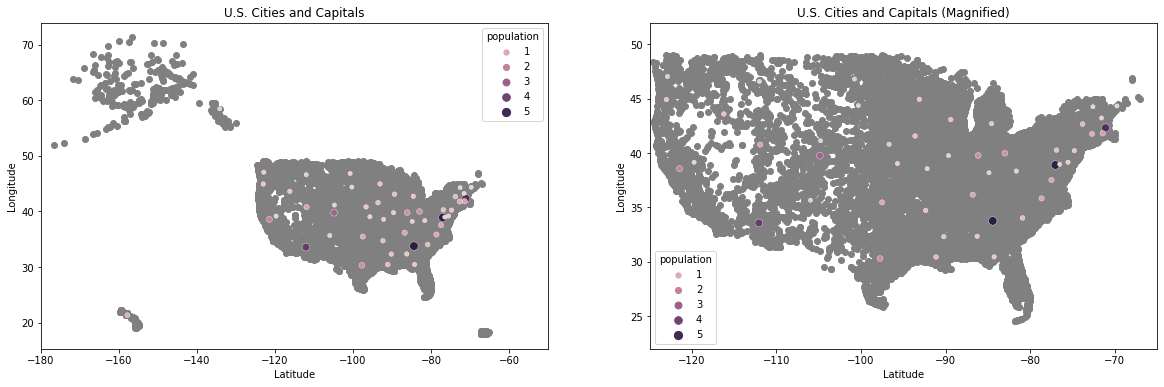

In [5]:
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
#norm = (min(us_cities['population']), max(us_cities['population']))

ax1.scatter(us_cities['long'], us_cities['lat'], c='#808080')
sn.scatterplot(data=capitals, x='long', y='lat', ax=ax1, hue='population', size='population')

ax2.scatter(us_cities['long'], us_cities['lat'], c='#808080')
sn.scatterplot(data=capitals, x='long', y='lat', ax=ax2, hue='population', size='population')
#sn.color_palette("viridis", as_cmap=True)

ax1.set_xlim([-180, -50])
ax2.set_xlim([-125, -65])
ax2.set_ylim(22, 52)

ax1.set_xlabel('Latitude'); ax1.set_ylabel('Longitude');
ax2.set_xlabel('Latitude'); ax2.set_ylabel('Longitude');

ax1.title.set_text('U.S. Cities and Capitals')
ax2.title.set_text('U.S. Cities and Capitals (Magnified)')

plt.show()

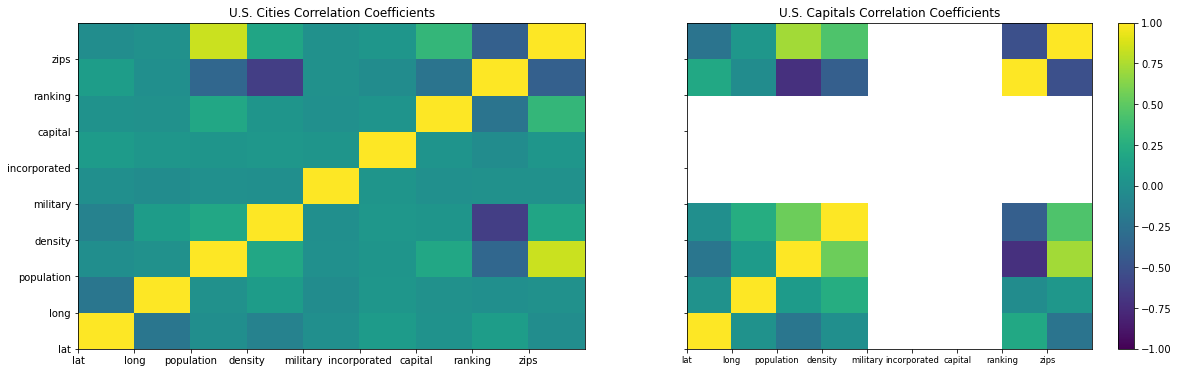

Correlation Matrix, All U.S. Cities:


lat      long  population   density  military  \
lat           1.000000 -0.215354   -0.016597 -0.110061 -0.009581   
long         -0.215354  1.000000    0.000170  0.097152 -0.034455   
population   -0.016597  0.000170    1.000000  0.187883 -0.004031   
density      -0.110061  0.097152    0.187883  1.000000 -0.008359   
military     -0.009581 -0.034455   -0.004031 -0.008359  1.000000   
incorporated  0.092169  0.049121    0.044540  0.055030  0.045228   
capital       0.008726  0.000463    0.194222  0.041689 -0.003399   
ranking       0.108250 -0.013467   -0.339824 -0.633011  0.005616   
zips         -0.030217  0.006120    0.840090  0.172560  0.002319   

              incorporated   capital   ranking      zips  
lat               0.092169  0.008726  0.108250 -0.030217  
long              0.049121  0.000463 -0.013467  0.006120  
population        0.044540  0.194222 -0.339824  0.840090  
density           0.055030  0.041689 -0.633011  0.172560  
military          0.045228 -0.003399  0.005616  0.002319  
incorporated      1.000000  0.035639 -0.036995  0.047268  
capital           0.035639  1.000000 -0.228524  0.324285  
ranking          -0.036995 -0.228524  1.000000 -0.393716  
zips              0.047268  0.324285 -0.393716  1.000000

Changes in Correlation, Incorporated Cities Only:


population
lat             0.007933
long            0.004743
population      0.000000
density        -0.020270
military        0.002029
incorporated         NaN
capital         0.001192
ranking         0.043834
zips           -0.002556

In [6]:
corr = us_cities.corr()
c_corr = capitals.corr()
i_corr = incorp.corr()

fig2, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(20, 6))

heatmap = ax1.pcolor(corr, vmin=-1, vmax=1)
heatmap = ax2.pcolor(c_corr, vmin=-1, vmax=1)
plt.colorbar(heatmap)

ax1.title.set_text('U.S. Cities Correlation Coefficients')
ax2.title.set_text('U.S. Capitals Correlation Coefficients')

labels=list(corr.index)
ticks = list(range(len(labels)))

_ = plt.xticks(ticks=ticks, labels=labels, size='small', stretch=150)
_ = plt.yticks(ticks=ticks, labels=labels, size='small')
plt.show()

print('Correlation Matrix, All U.S. Cities:')
display(corr)

print('Changes in Correlation, Incorporated Cities Only:')
display(pd.DataFrame(corr['population'] - i_corr['population']))

**INTERPRETATION:** From the outset


The correlation matrix above tells us a lot from the outset about the data and its relationships within. Most evident for the _capitals coefficient matrix_ on the right, the empty columns/rows show that any every state capital is a legitimate municipality and is not a military base (phew). Additionally, the correlations between capital cities and the other labels seem more significant than they would be for any non-capital.

A city's population *******

The 'ranking' variable appears to be most correlated to a city's density, population, and number of zip codes.

Pair Plot, All Incorporated
Pair Plot, Capitals


city state_id       state         county      lat      long  \
0            New York       NY    New York       New York  40.6943  -73.9249   
1         Los Angeles       CA  California    Los Angeles  34.1139 -118.4068   
2             Chicago       IL    Illinois           Cook  41.8373  -87.6862   
3               Miami       FL     Florida     Miami-Dade  25.7839  -80.2102   
4              Dallas       TX       Texas         Dallas  32.7936  -96.7662   
...               ...      ...         ...            ...      ...       ...   
12947  Four Mile Road       AK      Alaska  Yukon-Koyukuk  64.6045 -149.1222   
12948           Gross       NE    Nebraska           Boyd  42.9461  -98.5697   
12949          Lotsee       OK    Oklahoma          Tulsa  36.1334  -96.2091   
12950       The Ranch       MN   Minnesota       Mahnomen  47.3198  -95.6952   
12951          Monowi       NE    Nebraska           Boyd  42.8307  -98.3296   

       population  density  military  incorporated  capital  \
0        18713220    10715         0             1        0   
1        12750807     3276         0             1        0   
2         8604203     4574         0             1        0   
3         6445545     5019         0             1        0   
4         5743938     1526         0             1        0   
...           ...      ...       ...           ...      ...   
12947           3        1         0             1        0   
12948           2        6         0             1        0   
12949           2       39         0             1        0   
12950           2        2         0             1        0   
12951           1        1         0             1        0   

                  timezone  ranking  zips  
0         America/New_York        1   309  
1      America/Los_Angeles        1   196  
2          America/Chicago        1    85  
3         America/New_York        1    30  
4          America/Chicago        1   107  
...                    ...      ...   ...  
12947    America/Anchorage        3     1  
12948      America/Chicago        3     1  
12949      America/Chicago        3     1  
12950      America/Chicago        3     1  
12951      America/Chicago        3     1  

[12952 rows x 14 columns]

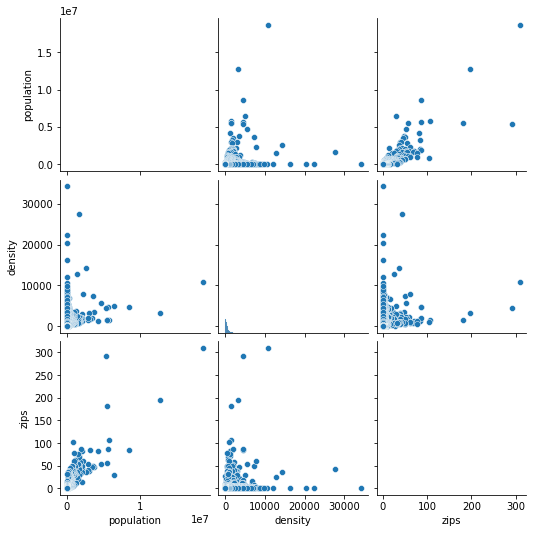

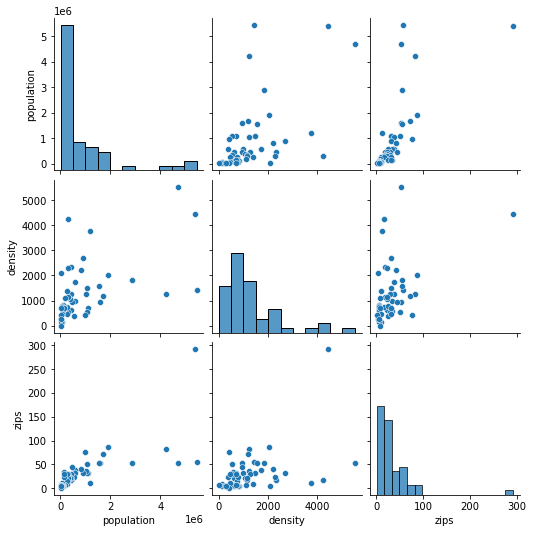

In [7]:
query = ['population', 'density', 'zips']
#Pair-Plot, all Cities
# print('Pair Plot, All Cities')
# sn.pairplot(us_cities[query])

print('Pair Plot, All Incorporated')
sn.pairplot(incorp[query])

print('Pair Plot, Capitals')
sn.pairplot(capitals[query])

incorp

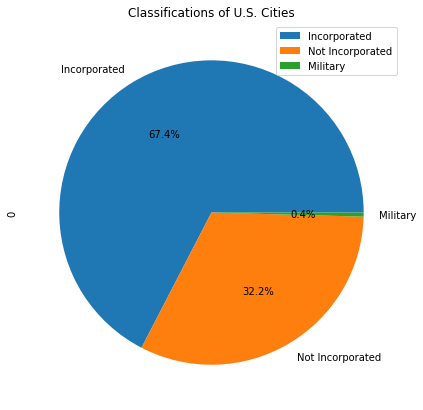

In [8]:
#All capitals and military bases are incorporated
labels = ['Incorporated', 'Not Incorporated', 'Military']
sizes = us_cities[['incorporated','military']].value_counts()
sizes = sizes.to_frame()
sizes.plot.pie(labels=labels, subplots=True, autopct='%1.1f%%', figsize=(10, 7))
_ = plt.title('Classifications of U.S. Cities')

During our exploratory analysis, we have seen that whether or not a city is labelled as 'incorporated' or 'military' has little to do with that city's population.

# Decomposition of City Features



# Decision Tree

To return city's population as quantile of national populations.

In [10]:
# tree.plot_tree

# predictors = ['lat', 'zips', 'density', 'incorporated']

# incorp['q'] = 
quant = np.arange(0.0, 1.0, 0.01)
S = i_funnel['population']

pq = (S - S.min())/(S.max() - S.min())
pq = pq.round(2)

print(np.mean(S)/S.max())
print(pq.value_counts())

#print(np.mean(pq))
#print(pq.value_counts())

#print(S.quantile(quant))


# features = ['lat', 'zips', 'density', 'incorporated'] 
# features = ['lat', 'zips', 'density'] 

# X = us_cities[features].values
# y = us_cities['population'].values
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2, test_size=0.6)

# decisionTree = tree.DecisionTreeClassifier()
# decisionTree = decisionTree.fit(X_train, y_train)

# y_pred_t = decisionTree.predict(X_train)
# print('Accuracy on training data= ', metrics.accuracy_score(y_true = y_train, y_pred = y_pred_t))

# y_pred = decisionTree.predict(X_test)
# print('Accuracy on test data= ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))

#import graphviz 
# dot_data = tree.export_graphviz(decisionTree, out_file=None) 
# graph = graphviz.Source(dot_data) 
# graph.render("iris") 

# dot_data = tree.export_graphviz(clf, out_file=None, 
#                      feature_names=iris.feature_names,  
#                      class_names=iris.target_names,  
#                      filled=True, rounded=True,  
#                      special_characters=True)  
# graph = graphviz.Source(dot_data)  
# graph  0.00026184

0.0045510131012733625
0.00    4873
0.01     436
0.02      86
0.03      39
0.04      17
0.05      14
0.08       7
0.06       7
0.07       7
0.13       6
0.16       4
0.12       4
0.09       3
0.23       3
0.17       3
0.43       2
0.14       2
0.11       2
0.15       1
0.20       1
0.67       1
0.33       1
0.45       1
0.42       1
0.27       1
0.30       1
0.44       1
0.37       1
0.28       1
0.51       1
1.00       1
0.25       1
Name: population, dtype: int64


<AxesSubplot:xlabel='population', ylabel='Count'>

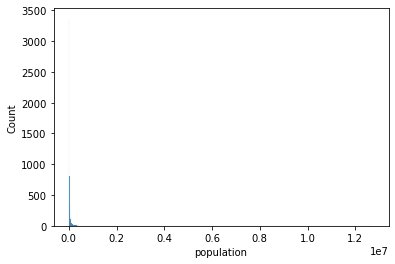

In [11]:
sn.histplot(S, bins=1000)

# Relationship between a City's Population and County

Until this point, we have not examined the relationship between a  city's population and its county. County lines can indicate geographical and political factors that correlate with a given city. Utah is a great example of this, given the geographical effects that the Great Salt Lake and Wasatch Front have on population density and distribution; and additionally with the political effects of districting, where urban populations tend to have smaller districts than rural. To put this potential relationship to the test, we will examine the states of California and New York as case studies and create models that classify population for each county.

In [22]:
mask = us_cities['state_id'] == 'CA'
CA = us_cities.loc[mask].sample(frac=1)

mask = us_cities['state_id'] == 'NY'
NY = us_cities.loc[mask].sample(frac=1)

county_n0 = {_:i for i,_ in enumerate(CA['county'].unique())}
CA['county_n'] = CA['county'].map(county_n0)

county_n1 = {_:i for i,_ in enumerate(NY['county'].unique())}
NY['county_n'] = NY['county'].map(county_n1)

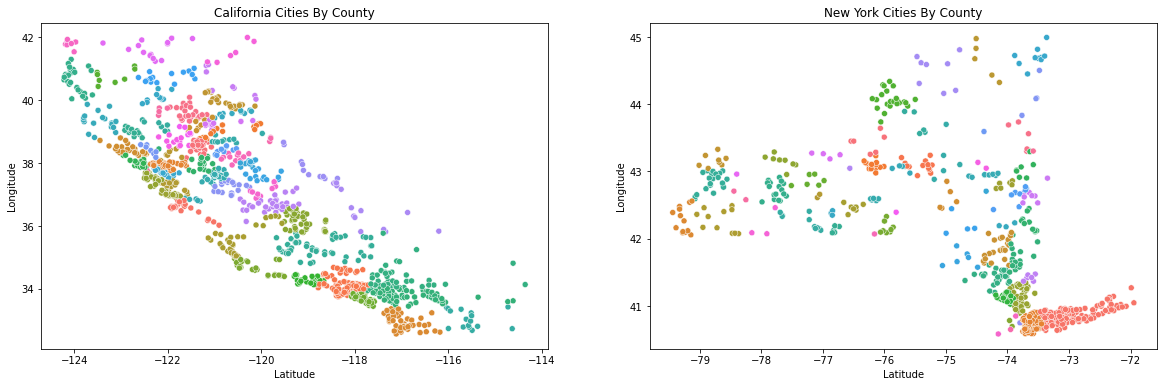

In [23]:
fig4, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

sn.scatterplot(data=CA, x='long', y='lat', ax=ax1, hue='county', legend=False)
sn.scatterplot(data=NY, x='long', y='lat', ax=ax2, hue='county', legend=False)

ax1.set_xlabel('Latitude'); ax1.set_ylabel('Longitude');
ax2.set_xlabel('Latitude'); ax2.set_ylabel('Longitude');

ax1.title.set_text('California Cities By County')
ax2.title.set_text('New York Cities By County')

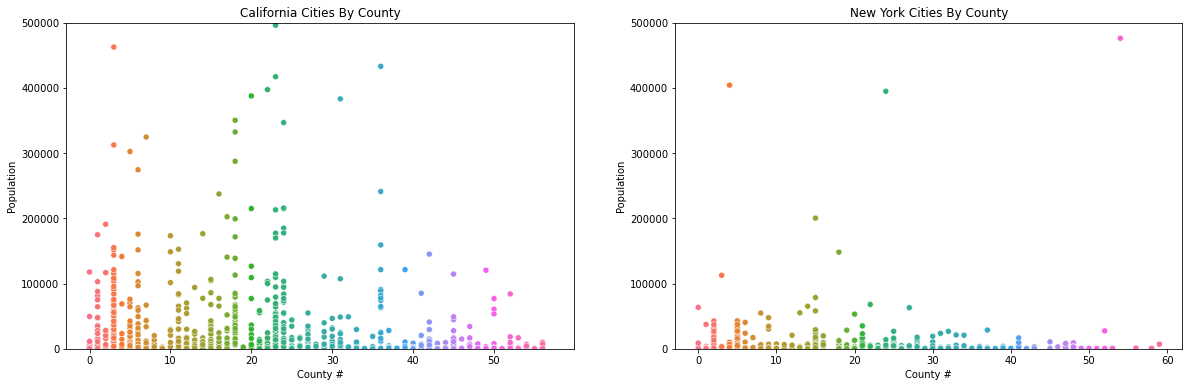

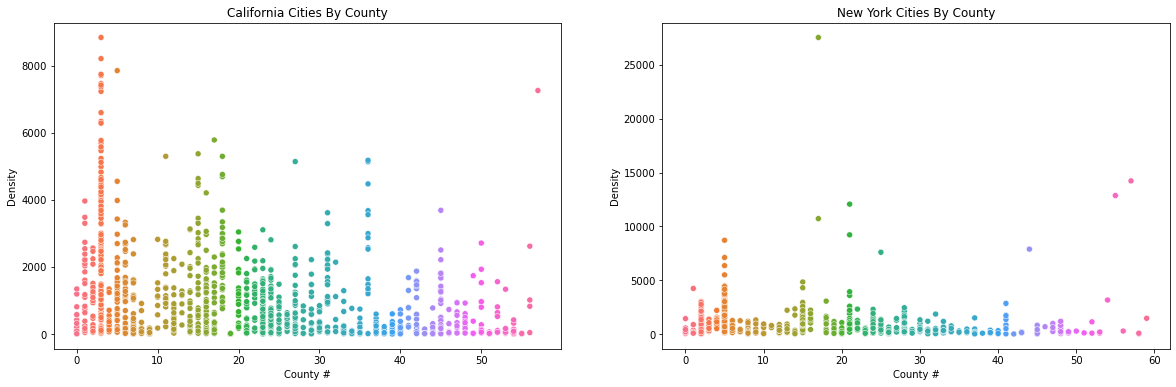

In [24]:
fig4, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

sn.scatterplot(data=CA, x='county_n', y='population', ax=ax1, hue='county', legend=False)
#ax2.scatter(us_cities['long'], us_cities['lat'], c='#808080')
sn.scatterplot(data=NY, x='county_n', y='population', ax=ax2, hue='county', legend=False)

ax1.set_xlabel('County #'); ax1.set_ylabel('Population');
ax2.set_xlabel('County #'); ax2.set_ylabel('Population');

ax1.set_ylim(-5, 5e5)
ax2.set_ylim(-5, 5e5)

ax1.title.set_text('California Cities By County')
ax2.title.set_text('New York Cities By County')


fig5, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

sn.scatterplot(data=CA, x='county_n', y='density', ax=ax1, hue='county', legend=False)
#ax2.scatter(us_cities['long'], us_cities['lat'], c='#808080')
sn.scatterplot(data=NY, x='county_n', y='density', ax=ax2, hue='county', legend=False)

ax1.set_xlabel('County #'); ax1.set_ylabel('Density');
ax2.set_xlabel('County #'); ax2.set_ylabel('Density');

# ax1.set_ylim(-5, 5e5)
# ax2.set_ylim(-5, 5e5)

ax1.title.set_text('California Cities By County')
ax2.title.set_text('New York Cities By County')

# Image Processing

In [16]:
#TODO - Process the RGB hists and intensities with a function, going through 

img_list = os.listdir('images/')[1:]
for img_name in img_list:
    img = Image.open('images/'+img_name)
    
img_list

['_Albany_2017_03_01.png',
 '_Albany_2020_05_01.png',
 '_Annapolis_2017_08_01.png',
 '_Annapolis_2019_06_01.png',
 '_Atlanta_2016_05_01.png',
 '_Atlanta_2017_03_01.png',
 '_Augusta_2016_05_01.png',
 '_Augusta_2017_07_01.png',
 '_Austin_2016_05_01.png',
 '_Austin_2019_05_01.png',
 '_Baton_Rouge_2016_05_01.png',
 '_Baton_Rouge_2020_05_01.png',
 '_Bismarck_2016_10_01.png',
 '_Bismarck_2019_06_01.png',
 '_Boise_2016_05_01.png',
 '_Boise_2019_05_01.png',
 '_Boston_2016_05_01.png',
 '_Boston_2020_04_01.png',
 '_Carson_City_2019_05_01.png',
 '_Carson_City_2020_05_01.png',
 '_Charleston_2017_04_01.png',
 '_Charleston_2020_03_01.png',
 '_Cheyenne_2016_06_01.png',
 '_Cheyenne_2020_05_01.png',
 '_Columbia_2016_05_01.png',
 '_Columbia_2017_04_01.png',
 '_Columbus_2016_05_01.png',
 '_Columbus_2017_03_01.png',
 '_Concord_2017_05_01.png',
 '_Concord_2020_05_01.png',
 '_Denver_2016_05_01.png',
 '_Denver_2019_10_01.png',
 '_Des_Moines_2017_05_01.png',
 '_Des_Moines_2020_03_01.png',
 '_Dover_2017_03_01.